# Environment

In [1]:
!cd ../&& pip install . &&cd -

Processing /Users/youngung/repo/texture3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for TEXTURElib: filename=TEXTURElib-0.0-py3-none-any.whl size=112927 sha256=842d917e542d51658b56e17eebe5ed2d8bf2b0743cf20a4b1ae6d81a38bc84ab
  Stored in directory: /private/var/folders/mj/8q7tbqkj36q7ymb0jmxhvlpw0000gn/T/pip-ephem-wheel-cache-v8gcspui/wheels/42/29/ad/bd6eca6154f0d67c79ac3105b8214a442614430fbb6edfa472
Successfully built TEXTURElib
  Attempting uninstall: TEXTURElib
    Found existing installation: TEXTURElib 0.0
    Uninstalling TEXTURElib-0.0:
      Successfully uninstalled TEXTURElib-0.0


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 3
from TX import upf
import numpy as np
from matplotlib.gridspec import GridSpec
from shapely import geometry
from shapely.geometry import Point
import scipy
import subprocess
from TX import bcc_rolling_fiber
import matplotlib
from shapely.geometry import Polygon
from scipy.interpolate import griddata
import subprocess
from TX import bcc_rolling_fiber
plt=matplotlib.pyplot
vector_ang=bcc_rolling_fiber.vector_ang
projection=upf.projection

In [3]:
filename='/Users/youngung/repo/evpsc/matData/vpscData/EDDQ/texture_opti/EDDQ1000'
#with open(filename,'r') as fo:
grs=np.loadtxt(filename,skiprows=4)

In [4]:
def xy_grid(shape):
    pi=np.pi
    nm,nn=np.array(shape,dtype='int')-1
    theta  = np.linspace(pi, pi/2., nn+1)
    phi    = np.linspace(0., 2.*pi, nm+1)
    r      = np.sin(theta)/(1-np.cos(theta))
    R, PHI = np.meshgrid(r,phi)
    x      = R*np.cos(PHI); y = R*np.sin(PHI)
    return x,y
    
def calc_symop(fnsx):
    cmd=f'./calc_cv {fnsx}'
    miller=[1,0,0,0]
    for i, ind in enumerate(miller): cmd=f'{cmd} {ind}'
    cmd=f'{cmd}  '
    # print(f'cmd: {cmd}')
    p=subprocess.Popen(cmd.split(),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    stdo,stde=p.communicate()
    # print(f'\n\n** stdo: {stdo.decode()}')
    lines=stdo.decode().split('\n')
    nsymop=int(lines[0].split('=')[-1])
    lines=lines[2:2+nsymop]
    #print(lines[0])
    #print(lines[-1])
    #for i in range(3):
    h=np.zeros((nsymop,3,3))
    for m, line in enumerate(lines):
        d=np.array(line.split()[1:],dtype='float')
        k=0
        for i in range(3):
            for j in range(3):
                h[m,i,j]=d[k]
                k=k+1
        #print(f'h: {h[m,:,:]}')
    return h

def proj(a):
    #print(f'a.shape:, {a.shape}')
    #print(f'len(a.shape): {len(a.shape)}')
    if len(a.shape)>1:
        vs=a.copy()
    elif len(a.shape)==1:
        vs=np.zeros((1,3))
        vs[0,:]=a[::]
    nvec=vs.shape[0]
    coords=np.zeros((nvec,2))
    for i, v in enumerate(vs):
        coords[i,:]=upf.projection(v)
    if len(a.shape)>1: return coords            
    elif len(a.shape)==1: return coords[0]

def circ():
    ths=np.linspace(-pi,pi)
    x=cos(ths);   y=sin(ths)
    return x,y

def gen_fig(nrows=3,ncols=3,colsize=2.5,rowsize=2.,**kwargs):
    gs=GridSpec(nrows=nrows,ncols=ncols,**kwargs)
    fig=plt.figure(figsize=(colsize*ncols,rowsize*nrows))
    axes=np.empty((nrows,ncols),dtype='object')
    for i in range(nrows):
        for j in range(ncols):
            ax=fig.add_subplot(gs[i,j])
            axes[i,j]=ax
    return fig,axes
def calc_vref_and_rot(a,b,fnsx,nang):
    """
    Given a miller-indexed crystal plane normal (a and b),
    calclulate the v ref and rotation matrices vref.
    """
    aca=-calc_cvec(a,fnsx)
    #print(f'b in calc_vref_and_rot {b}')
    bca=-calc_cvec(b,fnsx)
    #print(f'bca in calc_vref_and_rot {bca}')
    ## reference vector
    vref=np.cross(aca,bca)
    #print(f'vref: {vref}')
    #print(f'aca: {aca}')

    ##
    thf=np.arccos(np.dot(aca,bca))
    #print(f'thf: {np.rad2deg(thf)}')
    ths=np.linspace(0,thf,nang)
    rots=np.zeros((nang,3,3))
    varc=np.zeros((nang,3))
    
    for i, th in enumerate(ths):
        rots[i,:,:]=vector_ang(vref,np.rad2deg(th))
    return aca, bca, thf, vref, rots
    
    
def calc_arc(aca,rots):#a,b,fnsx,nang):
    """
    Arguments
    ---------
    aca crystal direction
    rots: rotation matrix
    """

    #aca, bca, thf, verf, rot = calc_vref_and_rot(a,b,fnsx,nang)
    nang=rots.shape[0]
    v_arc=np.zeros((nang,3))
    for i,rot in enumerate(rots):
        v_arc[i,:]=np.dot(rot,aca)
    return v_arc

def get_ipf_boundary(
    a=[0,0,1],b=[1,0,1],c=[1,1,1],nres=5,
    fnsx=None):
    
    pairs=[[a,b],[b,c],[c,a]]
    coords=np.zeros((2,(nres-1)*3+1))

    for i, pair in enumerate(pairs[:3]):
        #varc,vref=calc_arc(*pair,fnsx,nres)
        #print(varc.shape)
        aca,bca,thf,vref,rots=calc_vref_and_rot(*pair,fnsx,nres)
        varc=calc_arc(aca,rots)
        xy=proj(varc)
        i0=i*(nres-1)
        i1=i0+nres-1
        #print(f'i0,i1, {i0,i1}')
        coords[:,i0:i1]=xy[0:-1,:].T
    coords[:,-1]=coords[:,0]
    return coords
def calc_cvec(miller,fnsx):
    """
    Get a crystal vector of a Miller-indexed plane normal
    """
    cmd=f'./calc_cv {fnsx}'
    for i, ind in enumerate(miller): cmd=f'{cmd} {ind}'
    cmd=f'{cmd}  '
    #print(f'cmd: {cmd}')
    p=subprocess.Popen(cmd.split(),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    stdo,stde=p.communicate()
    #print(f'\n\n** stdo: {stdo.decode()}')
    #print(f'\n\n** stde: {stde.decode()}')    
    lines=stdo.decode().split('\n')
    nsymop=int(lines[0].split('=')[-1])
    lines[1:2+nsymop]
    #print('nsymop:',nsymop)
    rst= np.array(lines[2+nsymop:][0].split(),dtype='float')
    #print(f'miller: {miller}, rst: {rst}')
    return rst
    #return np.array(stdo.decode().split('\n')[0].split(),dtype='float')
def ipf_temp(**kw):
    """
    Create inverse pole figure boundaries (consisting of triangle and circle)
    """
    kw.update(nres=1000)
    bound1=get_ipf_boundary(**kw)
    bound2=upf.__circle__()
    bound2=np.array(bound2)
    return bound1, bound2    
def xy2_rtheta(x,y):
    """
    Convert from stereographically projected locations (X,Y)
    to that in 'R, Theta'
    """
    r=np.sqrt(x**2+y**2)
    th=np.arctan2(y,x)
    return r, th
def rad2phi(r):
    rinv=1./r
    rinv2=rinv**2
    return np.arcsin((rinv2-1)/(rinv2+1))

def gen_mask(boundary,x,y,shape):
    xb,yb=boundary
    poly=Polygon(zip(xb,yb))
    mask=np.empty(shape,dtype='object')
    for i in range(shape[0]):
        for j in range(shape[1]):
            p1,p2=x[i,j],y[i,j]
            if abs(p2)<1e-3: p2=1e-5 # a little trick to include the point on the horizontal line
            point=Point(p1,p2)
            mask[i,j]=not(point.within(poly))
    return mask

In [5]:
fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AA_jinhwa/sx_Al6061_affine.sx'

Elapsed time for calling cells_pf:          20 [ ms]
nsymop in cells_pf: 24
Elapsed time for calling cells_pf:          24 [ ms]

(-0.1, 0.4660254256401345)

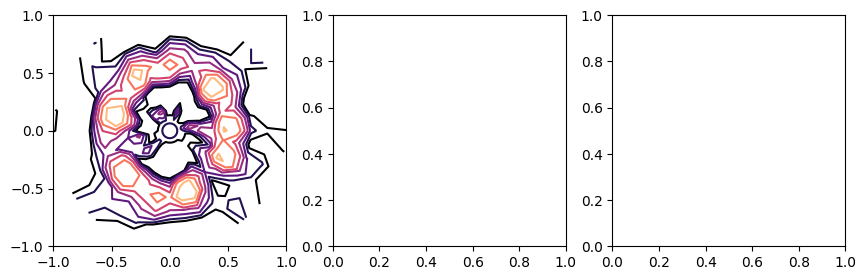

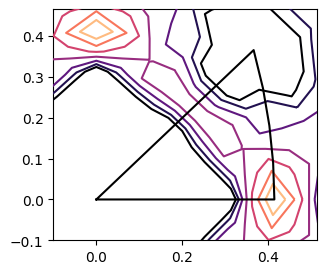

In [6]:
## build & install
#!echo '--' && cd ../&& pip install . |tail -n 3 &&cd - && echo '---\n'

#grs=np.array([[0,0,0,1]])
mypf=upf.polefigure(grains=grs[:,:],csym='cubic',cang=[90,90,90],cdim=[1,1,1])
fig=mypf.pf_new(poles=[[1,0,0],[1,1,0],[1,1,1]],proj='pf')#,mode='dot')
fig=mypf.pf_new(poles=[[1,0,0]],proj='ipf',mn=1.0,dph=5.) ## sample axis 1

## draw the triangle

boundary=get_ipf_boundary(fnsx=fnsx)
plt.gcf().axes[0].plot(*boundary,zorder=10,c='k')
plt.gcf().axes[0].set_xlim(boundary[0].min()-0.1,boundary[0].max()+0.1)
plt.gcf().axes[0].set_ylim(boundary[1].min()-0.1,boundary[1].max()+0.1)


nsymop in cells_pf: 24
Elapsed time for calling cells_pf:          21 [ ms]

(-0.1, 0.4660254256401345)

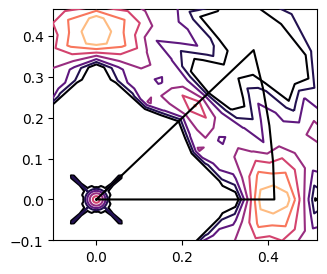

In [7]:
## build & install
#!echo '--' && cd ../&& pip install . |tail -n 3 &&cd - && echo '---\n'

#grs=np.array([[0,0,0,1]])
dth=9
dph=3.
mypf=upf.polefigure(grains=grs[:,:],csym='cubic',cang=[90,90,90],cdim=[1,1,1])
x,y,arr=mypf.pf_new(poles=[[1,0,0]],proj='ipf',mn=1.0,dth=dth,dph=dph) ## sample axis 1

plt.gcf().axes[0].plot(*boundary,zorder=10,c='k')
plt.gcf().axes[0].set_xlim(boundary[0].min()-0.1,boundary[0].max()+0.1)
plt.gcf().axes[0].set_ylim(boundary[1].min()-0.1,boundary[1].max()+0.1)

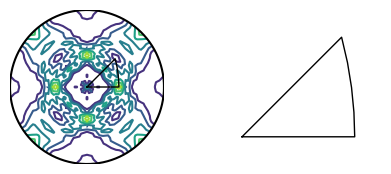

In [8]:
fig,axes=gen_fig(ncols=2,nrows=1)

#a=np.ma.array(arr[0],mask=PHI>np.deg2rad(45))
#a=np.ma.array(arr,mask=mask)
cnt=axes[0,0].contour(x,y,arr)
#cnt=axes[0,1].contour(x,y,a)

## draw the triangle
boundary=get_ipf_boundary(fnsx=fnsx)
axes[0,0].plot(*boundary,zorder=10,c='k',lw=1)
axes[0,1].plot(*boundary,zorder=10,c='k',lw=1)
axes[0,1].set_xlim(boundary[0].min()-0.1,boundary[0].max()+0.1)
axes[0,1].set_ylim(boundary[1].min()-0.1,boundary[1].max()+0.1)
axes[0,1].set_axis_off()
for i, ax in enumerate(fig.axes):
    ax.set_axis_off()
    ax.set_aspect('equal')
axes[0,0].plot(*upf.__circle__(),'-k')

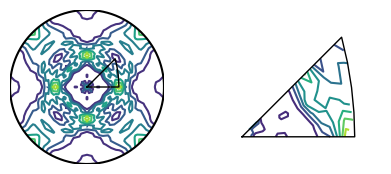

In [9]:
fig,axes=gen_fig(ncols=2,nrows=1)

mask=gen_mask(boundary,shape=x.shape,x=x,y=y)
a=np.ma.array(arr,mask=mask)
cnt=axes[0,0].contour(x,y,arr)
cnt=axes[0,1].contour(x,y,a,corner_mask=True)

## draw the triangle
boundary=get_ipf_boundary(fnsx=fnsx)
axes[0,0].plot(*boundary,zorder=10,c='k',lw=1)
axes[0,1].plot(*boundary,zorder=10,c='k',lw=1)
axes[0,1].set_xlim(boundary[0].min()-0.1,boundary[0].max()+0.1)
axes[0,1].set_ylim(boundary[1].min()-0.1,boundary[1].max()+0.1)
axes[0,1].set_axis_off()
for i, ax in enumerate(fig.axes):
    ax.set_axis_off()
    ax.set_aspect('equal')
axes[0,0].plot(*upf.__circle__(),'-k')

## Resampling using griddata


nsymop in cells_pf: 24
Elapsed time for calling cells_pf:          30 [ ms]order: 2
order: 3
order: 4


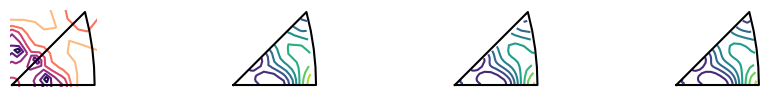

In [10]:
#grs=np.array([[0,0,0,1]])
orders=[2,3,4]

fig,axes=gen_fig(nrows=1,ncols=len(orders)+1,wspace=1.0,rowsize=1.0)

dth=10.
dph=10.
mypf=upf.polefigure(grains=grs[:,:],csym='cubic',cang=[90,90,90],cdim=[1,1,1])
x,y,arr=mypf.pf_new(axs=axes[0,0:1],poles=[[1,0,0]],proj='ipf',dth=dth,dph=dph) ## sample axis 1

boundary=get_ipf_boundary(fnsx=fnsx)
for i, order in enumerate(orders):
    print('order:',order)
    refined=scipy.ndimage.zoom(arr.T,order)
    x_,y_=xy_grid(refined.T.shape)
    #mask=gen_mask(boundary,x_.shape)
    mask=gen_mask(boundary,shape=x_.shape,x=x_,y=y_)
    a=np.ma.array(refined.T,mask=mask)
    cnt=axes[0,1+i].contour(x_,y_,a)

for i, ax in enumerate(axes.flatten()):
    ax.set_axis_off()
    ax.plot(*boundary,zorder=10,c='k' )
    ax.set_xlim(boundary[0].min()-0.01,boundary[0].max()+0.01)
    ax.set_ylim(boundary[1].min()-0.01,boundary[1].max()+0.01)
    ax.set_aspect('equal')
fig.savefig('/tmp/tmp.pdf')
!open /tmp/tmp.pdf


nsymop in cells_pf: 12
Elapsed time for calling cells_pf:          58 [ ms]order: 2
order: 3
order: 4


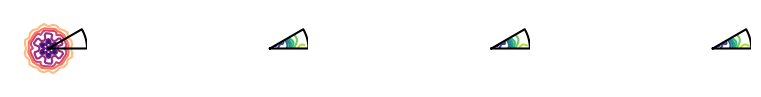

In [17]:
filename='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/AZ31_500.tex'
grs=np.loadtxt(filename,skiprows=4)
fnsx='/Users/youngung/repo/evpsc/matData/vpscData/AZ31_SCNU/sx'
cdim=[1,1,1.624]
cang=[90,90,120]
a=[0,0,0,1];b=[1,0,-1,0];c=[2,-1,-1,0]

csym='hexag'
poles=[[1,0,0],[0,1,0],[0,0,1]]





#grs=np.array([[0,0,0,1]])
orders=[2,3,4]
fig,axes=gen_fig(nrows=1,ncols=len(orders)+1,wspace=1.0,rowsize=1.0)

dth=10.
dph=10.
mypf=upf.polefigure(grains=grs[:,:],csym=csym,cang=cang,cdim=cdim)
x,y,arr=mypf.pf_new(axs=axes[0,0:1],poles=[[1,0,0]],proj='ipf',dth=dth,dph=dph) ## sample axis 1

boundary=get_ipf_boundary(a=a,b=b,c=c,fnsx=fnsx,nres=10)
for i, order in enumerate(orders):
    print('order:',order)
    refined=scipy.ndimage.zoom(arr.T,order)
    x_,y_=xy_grid(refined.T.shape)
    #mask=gen_mask(boundary,x_.shape)
    mask=gen_mask(boundary,shape=x_.shape,x=x_,y=y_)
    a=np.ma.array(refined.T,mask=mask)
    cnt=axes[0,1+i].contour(x_,y_,a)

for i, ax in enumerate(axes.flatten()):
    ax.set_axis_off()
    ax.plot(*boundary,zorder=10,c='k' )
    #ax.set_xlim(boundary[0].min()-0.01,boundary[0].max()+0.01)
    #ax.set_ylim(boundary[1].min()-0.01,boundary[1].max()+0.01)
    ax.set_aspect('equal')
fig.savefig('/tmp/tmp.pdf')
!open /tmp/tmp.pdf